In [1]:
!pip install librosa numpy tensorflow scikit-learn sounddevice
!pip install gradio

In [2]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from transformers import TFWav2Vec2Model, Wav2Vec2FeatureExtractor
from imblearn.over_sampling import SMOTE
from pydub import AudioSegment
import gradio as gr
import joblib
from sklearn.utils.class_weight import compute_class_weight

In [3]:
# === Configuration ===
SAMPLE_RATE = 16000  # Matches Wav2Vec2 requirements
DURATION = 3         # Standardize audio clips to 3 seconds
MAX_AUDIO_LENGTH = SAMPLE_RATE * DURATION
PRETRAINED_MODEL_NAME = "facebook/wav2vec2-base-960h"
DATASET_PATH = "/content/drive/MyDrive/dataset/YAF DATASET"  # Adjust this path as needed

# Initialize Wav2Vec2 model and feature extractor
wav2vec2 = TFWav2Vec2Model.from_pretrained(PRETRAINED_MODEL_NAME)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(PRETRAINED_MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(

TFWav2Vec2Model has backpropagation operations that are NOT supported on CPU. If you wish to train/fine-tune this model, you need a GPU or a TPU
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFWav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing TFWav2Vec2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a Be

In [4]:
# === Audio Preprocessing ===
def load_and_preprocess_audio(file_path):
    """Load and preprocess audio to a fixed length."""
    try:
        audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None
    if len(audio) < MAX_AUDIO_LENGTH:
        audio = np.pad(audio, (0, MAX_AUDIO_LENGTH - len(audio)))
    else:
        audio = audio[:MAX_AUDIO_LENGTH]
    return audio

In [5]:
# === Standard Data Augmentation ===
def augment(audio):
    """Apply random pitch shifting and noise addition (no time stretching)."""
    if np.random.rand() < 0.5:
        audio = librosa.effects.pitch_shift(audio, sr=SAMPLE_RATE, n_steps=np.random.uniform(-2, 2))
    if np.random.rand() < 0.5:
        noise = np.random.normal(0, 0.005, audio.shape)
        audio = audio + noise
    return audio


In [6]:
# === Feature Extraction ===
def extract_features(audio):
    """Extract full Wav2Vec2 feature sequence."""
    inputs = feature_extractor(audio, sampling_rate=SAMPLE_RATE, return_tensors="tf")
    wav_features = wav2vec2(inputs.input_values).last_hidden_state[0]  # Shape: (time_steps, 768)
    return wav_features.numpy()

In [7]:

# === Enhanced Data Loading ===
def load_enhanced_dataset(dataset_path):
    """Load dataset with speaker IDs and apply augmentation to minority classes."""
    features, labels, speakers = [], [], []
    for emotion in os.listdir(dataset_path):
        emotion_dir = os.path.join(dataset_path, emotion)
        if os.path.isdir(emotion_dir):
            for file in os.listdir(emotion_dir):
                if file.endswith(".wav"):
                    file_path = os.path.join(emotion_dir, file)
                    audio = load_and_preprocess_audio(file_path)
                    if audio is None:
                        continue
                    feat = extract_features(audio)
                    features.append(feat)
                    # Extract speaker ID from emotion label (e.g., 'YAF' from 'YAF_happy')
                    speaker_id = emotion.split('_')[0]
                    speakers.append(speaker_id)
                    labels.append(emotion)
                    # Augment for minority classes
                    if emotion in ['YAF_happy', 'YAF_sad']:
                        aug_audio = augment(audio)
                        aug_feat = extract_features(aug_audio)
                        features.append(aug_feat)
                        speakers.append(speaker_id)
                        labels.append(emotion)
    # Encode speaker IDs numerically
    speaker_encoder = LabelEncoder()
    speakers_encoded = speaker_encoder.fit_transform(speakers)
    return np.array(features), np.array(labels), speakers_encoded, speaker_encoder


In [8]:
# === Advanced Model Architecture ===
def build_enhanced_model(time_steps, feature_dim, num_speakers, num_classes):
    """Build a model with sequence input, speaker embedding, LSTM, and attention."""
    audio_input = tf.keras.Input(shape=(time_steps, feature_dim), name='audio_input')
    speaker_input = tf.keras.Input(shape=(1,), name='speaker_input')
    # Embed speaker ID and repeat across time steps
    speaker_embed = tf.keras.layers.Embedding(num_speakers, 8)(speaker_input)
    speaker_embed = tf.keras.layers.Flatten()(speaker_embed)
    speaker_embed = tf.keras.layers.RepeatVector(time_steps)(speaker_embed)
    # Combine audio and speaker features
    combined = tf.keras.layers.concatenate([audio_input, speaker_embed], axis=-1)
    # Bidirectional LSTM with attention
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(combined)
    x = tf.keras.layers.Attention()([x, x])
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    # Final Dense layer outputs raw logits (no activation)
    outputs = tf.keras.layers.Dense(num_classes, activation=None)(x)

    model = tf.keras.Model(inputs=[audio_input, speaker_input], outputs=outputs)
    # Fine-tuning: unfreeze wav2vec2 for adaptation
    wav2vec2.trainable = True
    optimizer = tf.keras.optimizers.Adam(1e-5)  # Low learning rate
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [9]:

# === Main Execution ===
if __name__ == "__main__":
    # Load dataset with speaker information
    X, y, speakers, speaker_encoder = load_enhanced_dataset(DATASET_PATH)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_onehot = to_categorical(y_encoded)

    # Handle class imbalance with SMOTE
    X_flat = X.reshape(-1, X.shape[1] * X.shape[2])
    smote = SMOTE()
    X_res_flat, y_res = smote.fit_resample(X_flat, y_encoded)
    X_res = X_res_flat.reshape(-1, X.shape[1], X.shape[2])
    y_res = to_categorical(y_res)


In [13]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res # Stratify by y_res
)

# Resample the speaker data to match the new data shape
speaker_res = np.repeat(speakers, np.ceil(len(X_res) / len(speakers)))[:len(X_res)]

# Now, split the resampled speaker data along with the data
speaker_train, speaker_test = train_test_split(
    speaker_res, test_size=0.2, random_state=42, stratify=y_res # Stratify by y_res
)

time_steps, feature_dim = X_train.shape[1], X_train.shape[2]
num_speakers = len(speaker_encoder.classes_) # Removed extra indentation
num_classes = y_onehot.shape[1] # Removed extra indentation

In [15]:
# Build and train model
model = build_enhanced_model(time_steps, feature_dim, num_speakers, num_classes)
model.summary()
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)

history = model.fit(
    [X_train, speaker_train], y_train,
    validation_data=([X_test, speaker_test], y_test),
    epochs=50,
    batch_size=32,
    class_weight=dict(enumerate(class_weights)),
    callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
    ]
    )

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ speaker_input             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1, 8)           │              8 │ speaker_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 8)              │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ audio_input (InputLayer)  │ (None, 149, 768)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 149, 8)         │              0 │ flatten[0][0]          │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 149, 776)       │              0 │ audio_input[0][0],     │
│                           │                        │                │ repeat_vector[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 149, 256)       │        926,720 │ concatenate[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 149, 256)       │              0 │ bidirectional[0][0],   │
│                           │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 256)            │              0 │ attention[0][0]        │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         32,896 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 5)              │            645 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 960,269 (3.66 MB)

 Trainable params: 960,269 (3.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.2126 - loss: 1.8167 - val_accuracy: 0.3550 - val_loss: 1.5980 - learning_rate: 1.0000e-05
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.2259 - loss: 1.7496 - val_accuracy: 0.3725 - val_loss: 1.5877 - learning_rate: 1.0000e-05
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.2732 - loss: 1.7249 - val_accuracy: 0.3900 - val_loss: 1.5707 - learning_rate: 1.0000e-05
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.2897 - loss: 1.6866 - val_accuracy: 0.4175 - val_loss: 1.5469 - learning_rate: 1.0000e-05
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3233 - loss: 1.6432 - val_accuracy: 0.4200 - val_loss: 1.5183 - learning_rate: 1.0000e-05
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.3692 - loss: 1.5907 - val_accuracy: 0.4400 - val_loss: 1.4816 - learning_rate: 1.0000e-05
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3881 

In [16]:
# Post-hoc calibration with temperature scaling
scaled_logits = model.output / 2.0  # Temperature scaling factor
calibrated_outputs = tf.keras.layers.Activation('softmax')(scaled_logits)
calibrated_model = tf.keras.Model(inputs=model.input, outputs=calibrated_outputs)

# Save calibrated model and encoders
calibrated_model.save("improved_emotion_model.keras")
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(speaker_encoder, 'speaker_encoder.pkl')

['speaker_encoder.pkl']

In [17]:
# === Gradio Interface ===
def convert_mp3_to_wav(mp3_filepath):
    """Convert MP3 to WAV for processing."""
    wav_filepath = mp3_filepath.replace('.mp3', '.wav')
    sound = AudioSegment.from_mp3(mp3_filepath)
    sound.export(wav_filepath, format="wav")
    return wav_filepath

In [18]:
def predict_emotion(audio_file):
    """Predict emotion from audio input using the trained model."""
    if audio_file.lower().endswith('.mp3'):
        audio_file = convert_mp3_to_wav(audio_file)
    audio = load_and_preprocess_audio(audio_file)
    features = extract_features(audio)
    speaker_id = np.array([0])  # Default speaker ID for inference
    pred = calibrated_model.predict([np.expand_dims(features, 0), speaker_id.reshape(-1, 1)])
    return label_encoder.inverse_transform([np.argmax(pred)])[0]

In [21]:
iface = gr.Interface(
    fn=predict_emotion,
    inputs=gr.Audio(type="filepath"),
    outputs="text",
    title="Enhanced Emotion Recognition",
    description="Record or upload audio (MP3/WAV) for emotion prediction with improved accuracy"
)


In [22]:
iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://962c8bd414079ad9b5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
# Post-hoc calibration with temperature scaling
scaled_logits = model.output / 2.0  # Temperature scaling factor
calibrated_outputs = tf.keras.layers.Activation('softmax')(scaled_logits)
calibrated_model = tf.keras.Model(inputs=model.input, outputs=calibrated_outputs)

# Re-compile the calibrated model with appropriate loss and metrics
calibrated_model.compile(optimizer=model.optimizer,  # Use the same optimizer
                  loss=tf.keras.losses.CategoricalCrossentropy(),  # Without from_logits=True
                  metrics=['accuracy'])  # Or any other desired metrics

In [27]:
# --- Evaluation ---

# Evaluate the calibrated model on the test set
test_loss, test_accuracy = calibrated_model.evaluate([X_test, speaker_test], y_test)
print("Test Loss: {:.4f}".format(test_loss))
print("Test Accuracy: {:.4f}".format(test_accuracy))

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8879 - loss: 0.5456
Test Loss: 0.5546
Test Accuracy: 0.8800


In [28]:
# Generate predictions on the test set
y_pred = calibrated_model.predict([X_test, speaker_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


In [29]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

   YAF_angry       0.94      0.91      0.92        80
    YAF_fear       0.92      0.96      0.94        80
   YAF_happy       0.83      0.85      0.84        80
 YAF_neutral       0.85      0.96      0.90        80
     YAF_sad       0.88      0.71      0.79        80

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400



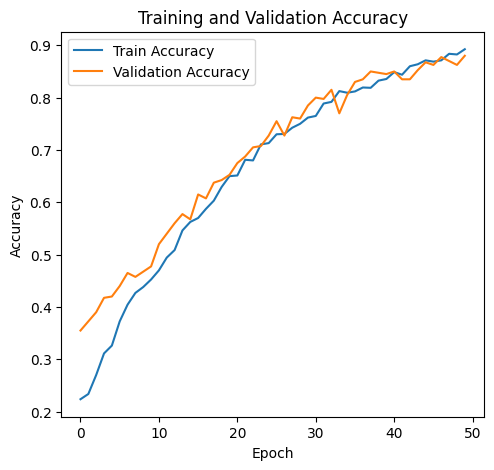

In [30]:
# Plot training & validation accuracy and loss over epochs
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

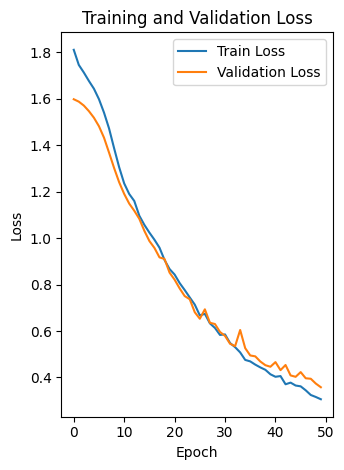

In [31]:
# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


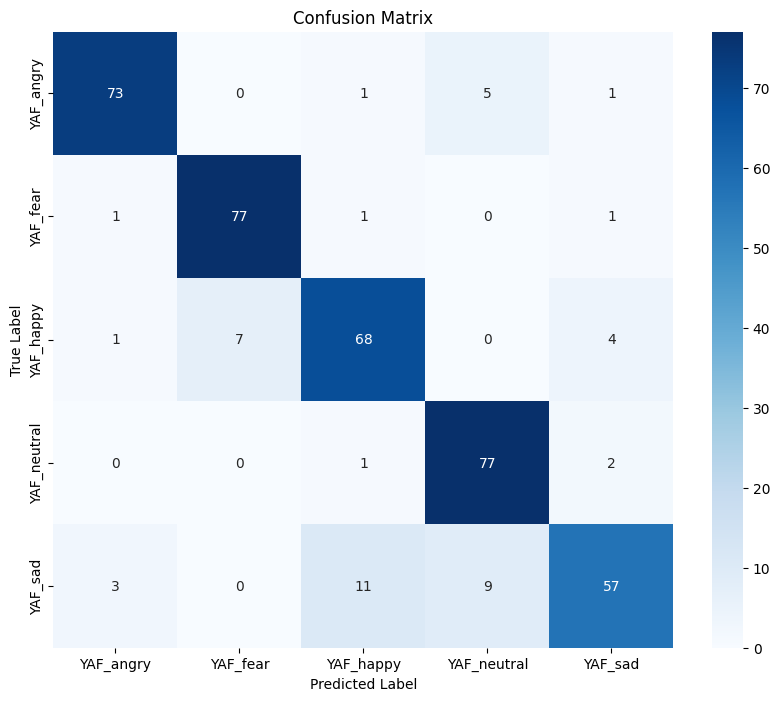

In [32]:
# Plot Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

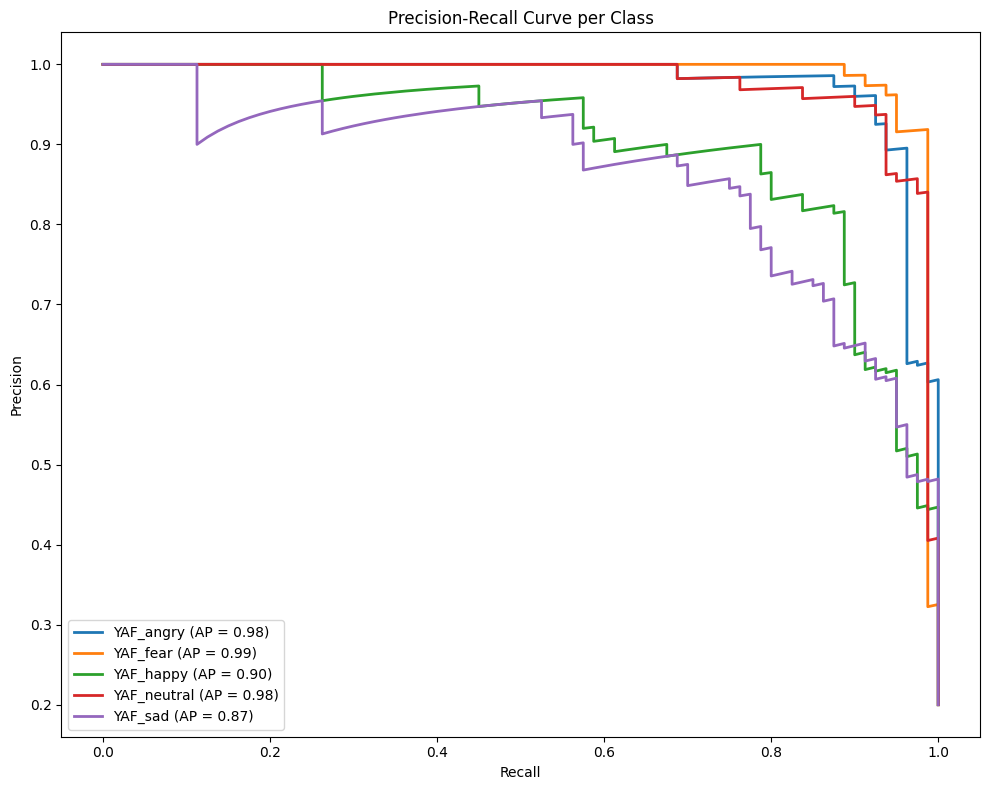

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Assuming y_test is one-hot encoded and y_pred are the predicted probabilities.
n_classes = y_test.shape[1]

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    average_precision = average_precision_score(y_test[:, i], y_pred[:, i])
    plt.plot(recall, precision, lw=2,
             label=f'{label_encoder.classes_[i]} (AP = {average_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve per Class')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
